# Wavelength calibration

This notebook assumes you've completed the Spectroscopic Trace process and have a trace handy.

In [1]:
from PIL import Image
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background')

We have three calibration lamp spectra: Mercury, Krypton, and Neon.

In [2]:
hg_filename = "hg_lamp_1-sixteenth_s.bmp"
kr_filename = "kr_lamp_p6.bmp"
ne_filename = "ne_lamp_1s.bmp"

In [3]:
hg_image = np.array(Image.open(hg_filename))
kr_image = np.array(Image.open(kr_filename))
ne_image = np.array(Image.open(ne_filename))

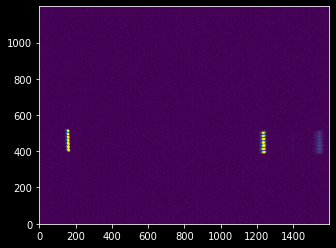

In [4]:
pl.imshow(hg_image)

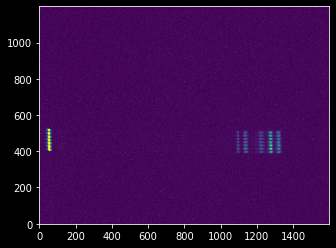

In [5]:
pl.imshow(kr_image)

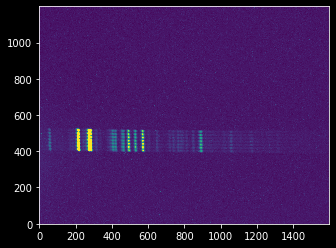

In [6]:
pl.imshow(ne_image)

We can note by zooming in that there appear to be seven independent spectra:

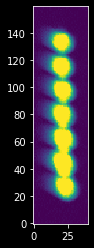

In [7]:
pl.imshow(hg_image[380:540,140:180])

We re-create our trace model from the [Spectroscopic Trace Tutorial](Spectroscopic%20Trace%20Tutorial.ipynb) using the fitted models.

(we could have used the empirical trace directly, which might result in slightly improved noise characteristics, but for simplicity - and to make the two notebooks independently usable - we use the fitted polynomial & Gaussian models here)

In [8]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D
trace_model = Polynomial1D(degree=2, c0=453.99089409, c1=-0.01931577, c2=0.00000731,)
trace_profile_model = Gaussian1D(amplitude=123.81906886, mean=0.17890498, stddev=5.10870321)
xaxis = np.arange(hg_image.shape[1])
trace_center = trace_model(xaxis)
npixels_to_cut=15
yaxis = np.arange(-npixels_to_cut, npixels_to_cut)
model_trace_profile = trace_profile_model(yaxis)

Then, we use the trace to extract spectra from each of the three calibration lamp spectra.

We verify that the traces look acceptable first, though:

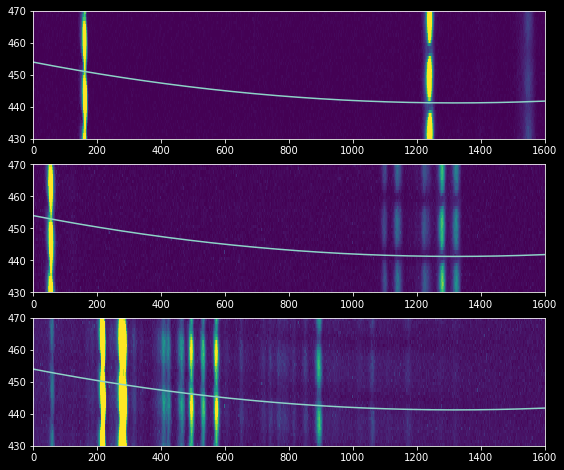

In [9]:
pl.figure(figsize=(16,8))
ax1 = pl.subplot(3,1,1)
ax1.imshow(hg_image[430:470,:], extent=[0,1600,430,470])
ax1.plot(xaxis, trace_center)
ax1.set_aspect(10)
ax2 = pl.subplot(3,1,2)
ax2.imshow(kr_image[430:470,:], extent=[0,1600,430,470])
ax2.plot(xaxis, trace_center)
ax2.set_aspect(10)
ax3 = pl.subplot(3,1,3)
ax3.imshow(ne_image[430:470,:], extent=[0,1600,430,470])
ax3.plot(xaxis, trace_center)
ax3.set_aspect(10)

Strangely, the trace looks like it's going through a minimum between the individual spectra, but there's enough signal that we can extract a calibration lamp spectrum, and the trace is perpendicular enough to the dispersion axis that we can mostly trust it.  Nonetheless, you might question whether these observations were carried out correctly, or if the spectrograph was shaken severely between star & cal lamp observations.

In [10]:
hg_spectrum = np.array([np.average(hg_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [11]:
ne_spectrum = np.array([np.average(ne_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

In [12]:
kr_spectrum = np.array([np.average(kr_image[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=model_trace_profile)
                     for yval, ii in zip(trace_center, xaxis)])

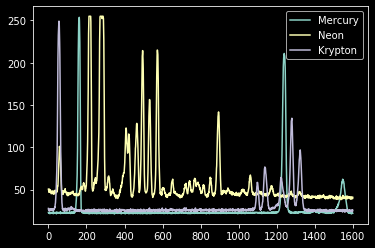

In [13]:
_=pl.plot(xaxis, hg_spectrum, label='Mercury')
_=pl.plot(xaxis, ne_spectrum, label='Neon')
_=pl.plot(xaxis, kr_spectrum, label='Krypton')
_=pl.legend(loc='best')

We now have spectra of a mercury lamp, a neon lamp, and a krypton lamp.

If we have no prior knowledge, we have to do some guess-and-check, but wikipedia's a decent resource to point us at the right line lists:

 * https://en.wikipedia.org/wiki/Mercury-vapor_lamp#Emission_line_spectrum
 * https://en.wikipedia.org/wiki/Gas-discharge_lamp#Color

In [14]:
from IPython.display import Image

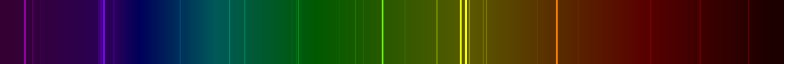

In [15]:
Image("https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg")

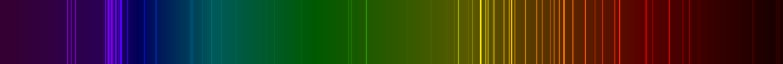

In [16]:
Image("https://upload.wikimedia.org/wikipedia/commons/9/99/Neon_spectra.jpg")

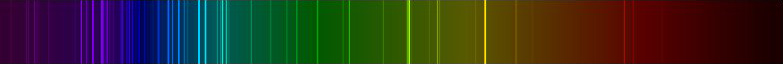

In [17]:
Image("https://upload.wikimedia.org/wikipedia/commons/a/a6/Krypton_Spectrum.jpg")

In [18]:
from astropy import units as u

Start with mercury...

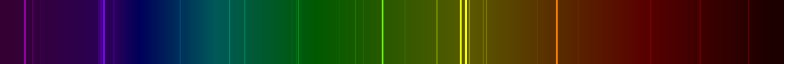

In [19]:
Image("https://upload.wikimedia.org/wikipedia/commons/2/29/Mercury_Spectra.jpg")

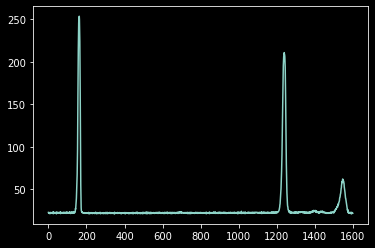

In [20]:
pl.plot(xaxis, hg_spectrum)

In [21]:
# Guessing these is hard and takes experience
# I figured this out by noting that an A-star we observed, Deneb, had an absorption line around pixel ~750
# That absorption line pretty much has to be H-alpha or H-beta
guessed_wavelengths = [546.1, 435.8, 404.7]
guessed_xvals = [165, 1230, 1550]

We can do a lot better at determining the X-values by taking the intensity-weighted coordinate (moment 1):

In [22]:
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=hg_spectrum[g-npixels:g+npixels] - np.median(hg_spectrum))
                         for g in guessed_xvals]
improved_xval_guesses

[160.74841515463885, 1235.174089249926, 1548.3534664431377]

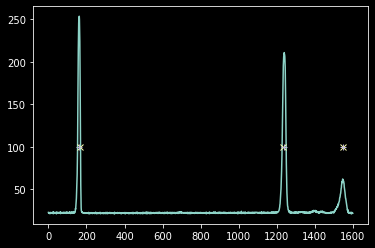

In [23]:
pl.plot(xaxis, hg_spectrum)
pl.plot(guessed_xvals, [100]*3, 'x')
pl.plot(improved_xval_guesses, [100]*3, '+')

We only have three data points, but that is enough to fit a linear model and still have a free point to check that we got it close to right:

In [24]:
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

We use a `Linear1D` model because we will want to use its inverse later

In [25]:
from astropy.modeling.models import Linear1D
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(xaxis) * u.nm
linfit_wlmodel

<Linear1D(slope=-0.1020971, intercept=562.40068141)>

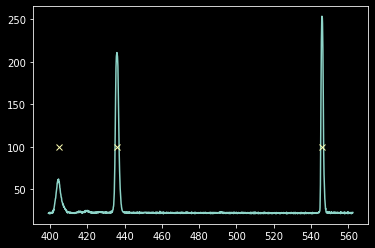

In [26]:
pl.plot(wavelengths, hg_spectrum)
pl.plot(guessed_wavelengths, [100]*3, 'x')

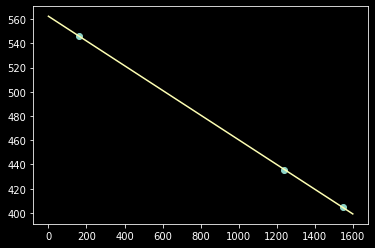

In [27]:
pl.plot(improved_xval_guesses, guessed_wavelengths, 'o')
pl.plot(xaxis, wavelengths, '-')

Indeed, a linear model fit excellently!

We can look up neon and krypton line lists to see how well we did and maybe try to improve our fit.

NIST, the National Institute of Standards and Technology, maintains [atomic line lists](https://physics.nist.gov/PhysRefData/ASD/lines_form.html).  However, we have no direct way to know which transitions from these atoms to use!  There are a few heuristics we can apply, though.

In [28]:
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
# we adopt the minimum/maximum wavelength from our linear fit
minwave = wavelengths.min()
maxwave = wavelengths.max()
# then we search for atomic lines
# We are only interested in neutral lines, assuming the lamps are not hot enough to ionize the atoms
mercury_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Hg I')
krypton_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='Kr I')
neon_lines = Nist.query(minwav=minwave,
                        maxwav=maxwave,
                        linename='Ne I')

We can first look at what NIST reports for the mercury spectrum we already fit:

(note that the wavelengths are *air* wavelengths, not vacuum)

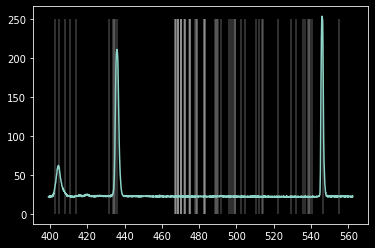

In [29]:
pl.plot(wavelengths, hg_spectrum)
pl.vlines(mercury_lines['Observed'], 0, 250, 'w', alpha=0.25)

The database contains *many* more lines than we saw.

The "Rel. Int" (Relative Intensity) provides "a qualitative description of what the emission spectrum of a particular element in a particular (low-density) source looks like." 

We can select that column, if we clean it up a little (there are some "blank" entries)

In [30]:
# these lines downselect from the table to keep only those that have usable "Relative Intensity" measurements
# first, we get rid of those whose 'Rel.' column is masked out or is an asterisk
hg_keep = (~mercury_lines['Rel.'].mask) & (mercury_lines['Rel.'] != "*")
hg_wl_tbl = mercury_lines['Observed'][hg_keep]
# then, we collect the 'Rel.' values and convert them from strings to floats
hg_rel_tbl = np.array([float(x) for x in mercury_lines['Rel.'][hg_keep]])

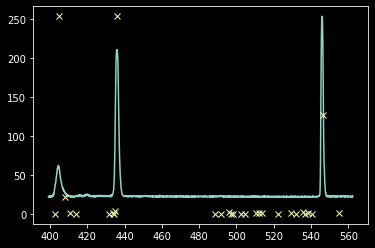

In [31]:
pl.plot(wavelengths, hg_spectrum)
# we normalize the relative intensities to match the intensity of the spectrum so we can see both on the same plot
# since they're just relative intensities, their amplitudes are arbitrary anyway
pl.plot(hg_wl_tbl, hg_rel_tbl / hg_rel_tbl.max() * hg_spectrum.max(), 'x')

Not bad!  See that only the three "brightest" lines show up, plus maybe a bit of a third one around 408 nm.

Let's try the same for the other lines (note that the hackery changes - this is because the NIST tables are not formatted to be machine-readable!)

In [32]:
ne_keep = np.array(['*' not in x for x in neon_lines['Rel.']])
ne_wl_tbl = neon_lines['Observed'][ne_keep]
ne_rel_tbl = np.array([float(x) for x in neon_lines['Rel.'][ne_keep]])

In [33]:
kr_keep = np.array([('*' not in x) and ('h' not in x) and ('-' not in x) for x in krypton_lines['Rel.']])
kr_wl_tbl = krypton_lines['Observed'][kr_keep]
kr_rel_tbl = np.array([float(x) for x in krypton_lines['Rel.'][kr_keep]])

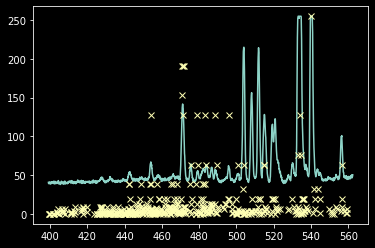

In [34]:
pl.plot(wavelengths, ne_spectrum)
pl.plot(ne_wl_tbl, ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max(), 'x')

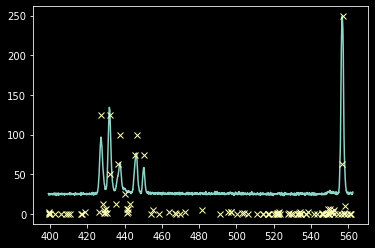

In [35]:
pl.plot(wavelengths, kr_spectrum)
pl.plot(kr_wl_tbl, kr_rel_tbl / kr_rel_tbl.max() * kr_spectrum.max(), 'x')

The Krypton spectrum will be much easier to deal with: we just select those lines with intensities > 70 on the scale above:

In [36]:
kr_rel_intens =  kr_rel_tbl / kr_rel_tbl.max() * kr_spectrum.max()
kr_keep_final = kr_rel_intens > 70
kr_wl_final = kr_wl_tbl[kr_keep_final]

We then take these krypton wavelengths and convert them back to pixel space:

In [37]:
# the linear model has an inverse function that takes y = m x + b and converts to x = (y - b) / m
kr_pixel_vals = linfit_wlmodel.inverse(kr_wl_final)

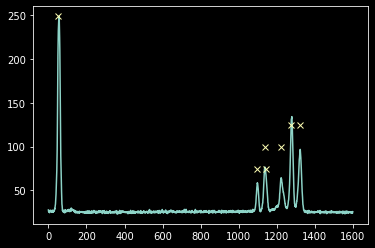

In [38]:
pl.plot(xaxis, kr_spectrum)
pl.plot(kr_pixel_vals, kr_rel_intens[kr_keep_final], 'x')

As with mercury above, we select a sub-region and measure the intensity-weighted peak position in pixel number to accurately measure the pixel center.

But here we have to be careful!  These peaks are very close!  Can we still use a +/-15 pixel range?

(1200, 1350)

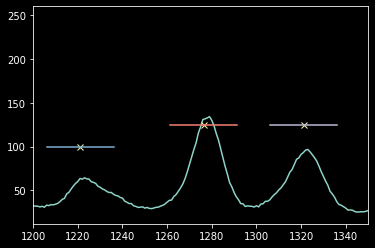

In [39]:
# Examine the pixel range, +/-15 pix, to see if it results in line overlaps
pl.plot(xaxis, kr_spectrum)
pl.plot(kr_pixel_vals, kr_rel_intens[kr_keep_final], 'x')
for xx, yy in zip(kr_pixel_vals, kr_rel_intens[kr_keep_final]):
    pl.plot([xx-15,xx+15], [yy,yy], ) # plot horizontal lines at each peak location
pl.xlim(1200,1350)

Yes, 15 pixels looks OK still.

If these lines had overlapped with one another at all, we would have wanted to decrease the pixel range.

In [40]:
# note that we have to force the pixel-center guesses to be integers for slicing:
npixels = 15
improved_xval_guesses_kr = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=kr_spectrum[g-npixels:g+npixels] - np.median(kr_spectrum))
                         for g in map(int, kr_pixel_vals)]
improved_xval_guesses_kr

[1321.368643420464,
 1277.1970344530764,
 1222.9733182016114,
 1140.2779949860676,
 1137.751605014417,
 1097.7153064145145,
 54.31747422508627]

Now we can plot these best-fit pixel numbers against the "true" wavelengths and overplot our previous best-fit model from mercury:

Text(0, 0.5, 'Wavelength (nm)')

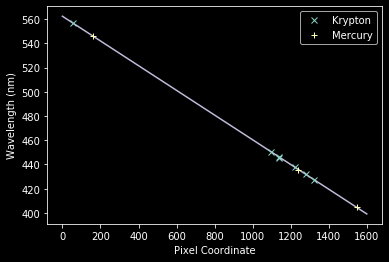

In [41]:
pl.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
pl.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")

We can now jointly fit the Kr + Hg spectra with a new model:

In [42]:
# we concatenate the data sets together
xvals_hg_plus_kr = np.concatenate([improved_xval_guesses,
                                   improved_xval_guesses_kr])
waves_hg_plus_kr = np.concatenate([guessed_wavelengths, kr_wl_final])
linfit_wlmodel_hgkr = linfitter(model=wlmodel,
                                x=xvals_hg_plus_kr,
                                y=waves_hg_plus_kr)
linfit_wlmodel_hgkr

<Linear1D(slope=-0.10221974, intercept=562.57081039)>

Text(0, 0.5, 'Wavelength (nm)')

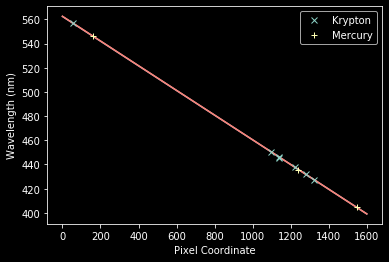

In [43]:
# re-plot the data with the fit overlaid
pl.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
pl.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.plot(xaxis, linfit_wlmodel_hgkr(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")

These are nearly indistiguishable, but let's look at the residuals for each:

(array([2., 0., 0., 0., 0., 3., 1., 2., 1., 1.]),
 array([-0.51163415, -0.42032265, -0.32901115, -0.23769965, -0.14638815,
        -0.05507665,  0.03623486,  0.12754636,  0.21885786,  0.31016936,
         0.40148086]),
 <a list of 1 Patch objects>)

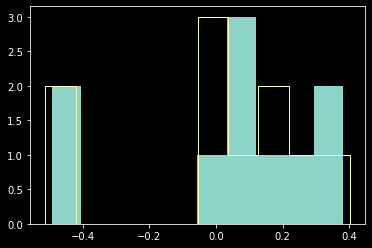

In [44]:
residuals_hgonlymodel = np.array(waves_hg_plus_kr) - linfit_wlmodel(xvals_hg_plus_kr)
residuals_hgkrmodel = np.array(waves_hg_plus_kr) - linfit_wlmodel_hgkr(xvals_hg_plus_kr)
pl.hist(residuals_hgonlymodel, label='Hg-only fit', histtype='stepfilled')
pl.hist(residuals_hgkrmodel, label='Hg-only fit', histtype='step')

The differences are pretty marginal; the Hg-only fit was really good.

Is there any shape to the residuals?

Text(0, 0.5, 'Wavelength residual (data minus model; nm)')

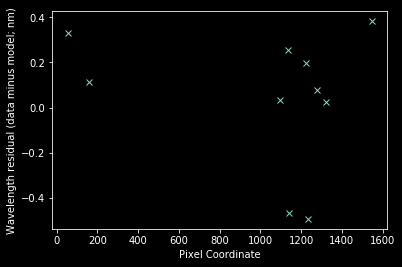

In [45]:
pl.plot(xvals_hg_plus_kr, residuals_hgonlymodel, 'x')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength residual (data minus model; nm)")

Text(0, 0.5, 'Wavelength residual (data minus model; nm)')

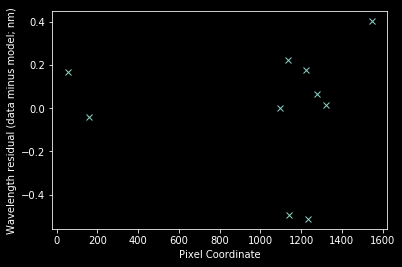

In [46]:
pl.plot(xvals_hg_plus_kr, residuals_hgkrmodel, 'x')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength residual (data minus model; nm)")

In brief, no, there's no sign of structure.

We can also estimate a chi-squared-like statistic (though note that this is *not* the $\chi^2$ value we would use to assess goodness of fit because we have *not* estimated the uncertainty on each wavelength point!)

In [47]:
resid2_hgonly = (residuals_hgonlymodel**2).sum()
resid2_hgkr = (residuals_hgkrmodel**2).sum()
resid2_hgonly, resid2_hgkr

(0.8363706114049698, 0.7825190622506862)

These differences are also very small, again suggesting the Hg-only fit was really good.

Why do we bother going through all these checks if the Hg-only fit was just fine?  

Besides simply not knowing, it is common for spectrographs to have slightly non-linear dispersion when measured over a wide wavelength range, so we want to be sure we haven't missed any such curvature.

We also want to measure the uncertainty on our wavelength calibration.

Now let's go back and measure the Neon spectrum

Text(0.5, 0, 'Wavelength (nm)')

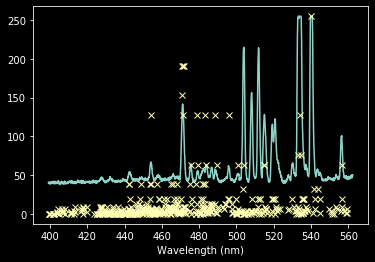

In [48]:
ne_rel_intens = ne_rel_tbl / ne_rel_tbl.max() * ne_spectrum.max()
pl.plot(wavelengths, ne_spectrum)
pl.plot(ne_wl_tbl, ne_rel_intens, 'x')
pl.xlabel('Wavelength (nm)')

We can try keeping only those with intensiy >100, though we will miss some lines

Text(0.5, 0, 'Wavelength (nm)')

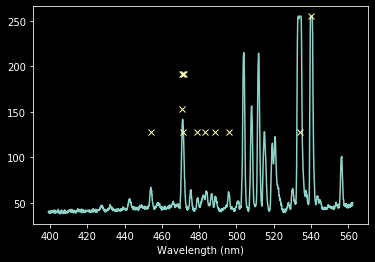

In [49]:
ne_keep_final = ne_rel_intens > 100
pl.plot(wavelengths, ne_spectrum)
pl.plot(ne_wl_tbl[ne_keep_final], ne_rel_intens[ne_keep_final], 'x')
pl.xlabel('Wavelength (nm)')

In [50]:
# select down to just those lines we want to keep
ne_wl_final = ne_wl_tbl[ne_keep_final]
ne_pixel_vals = linfit_wlmodel.inverse(ne_wl_final)

Text(0.5, 0, 'Wavelength (nm)')

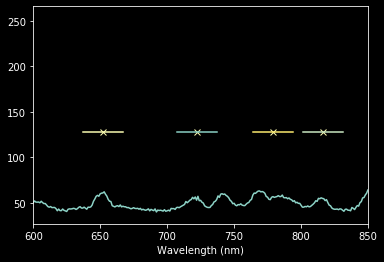

In [51]:
# check for overlaps again (in the densest part of the spectrum)
pl.plot(xaxis, ne_spectrum)
pl.plot(ne_pixel_vals, ne_rel_intens[ne_keep_final], 'x')
for xx, yy in zip(ne_pixel_vals, ne_rel_intens[ne_keep_final]):
    pl.plot([xx-15,xx+15], [yy,yy], )
pl.xlim(600,850)
pl.xlabel('Wavelength (nm)')

For Neon, our automated approach isn't very good (the third point from the left is not on a peak), and we'll want to use a narrower pixel range.

Still, rather than go back through and laboriously identify each line, we'll stick with a semi-automated approach.

In [52]:
npixels = 10
improved_xval_guesses_ne = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=ne_spectrum[g-npixels:g+npixels] - np.median(ne_spectrum))
                         for g in map(int, ne_pixel_vals)]
improved_xval_guesses_ne

[1060.518206131114,
 895.2423955745494,
 893.6707758321222,
 892.9232261988394,
 892.0819665037286,
 890.6754668088995,
 814.2324198121928,
 776.6287871855463,
 720.1156907937195,
 651.4261613260562,
 275.4823600729216,
 216.90680083485148]

Text(0, 0.5, 'Wavelength (nm)')

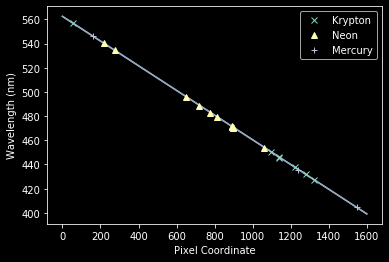

In [53]:
pl.plot(improved_xval_guesses_kr, kr_wl_final, 'x', label='Krypton')
pl.plot(improved_xval_guesses_ne, ne_wl_final, '^', label='Neon')
pl.plot(improved_xval_guesses, guessed_wavelengths, '+', label='Mercury')
pl.plot(xaxis, wavelengths, zorder=-5)
pl.plot(xaxis, linfit_wlmodel_hgkr(xaxis), zorder=-5)
pl.legend(loc='best')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength (nm)")

We concatenate the Neon lines onto the spectrum and re-fit again

In [54]:
xvals_hg_plus_kr_plus_ne = list(improved_xval_guesses) + list(improved_xval_guesses_kr) + list(improved_xval_guesses_ne)
waves_hg_plus_kr_plus_ne = list(guessed_wavelengths) + list(kr_wl_final) + list(ne_wl_final)
linfit_wlmodel_hgkrne = linfitter(model=wlmodel, x=xvals_hg_plus_kr_plus_ne, y=waves_hg_plus_kr_plus_ne)
linfit_wlmodel_hgkrne

<Linear1D(slope=-0.10213643, intercept=562.3862495)>

In [55]:
residuals_hgmodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel(xvals_hg_plus_kr_plus_ne)
residuals_hgkrmodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel_hgkr(xvals_hg_plus_kr_plus_ne)
residuals_hgkrnemodel_nedata = np.array(waves_hg_plus_kr_plus_ne) - linfit_wlmodel_hgkrne(xvals_hg_plus_kr_plus_ne)

In [56]:
# calculate and compare the squared residuals
# the model calculated for Hg-only works better than that for Krypton, but the optimal linear model is calculated
# from all data, with a squared residual of 1.26 nm
resid2_hgonly = (residuals_hgmodel_nedata**2).sum()
resid2_hgkr = (residuals_hgkrmodel_nedata**2).sum()
resid2_hgkrne = (residuals_hgkrnemodel_nedata**2).sum()
resid2_hgonly, resid2_hgkr, resid2_hgkrne

(1.3243219017297971, 1.5659010250241754, 1.2669374480579132)

Text(0, 0.5, 'Wavelength residual (data minus model; nm)')

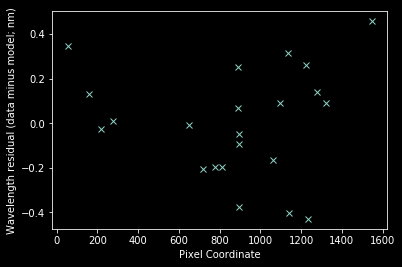

In [57]:
pl.plot(xvals_hg_plus_kr_plus_ne, residuals_hgkrnemodel_nedata, 'x')
pl.xlabel("Pixel Coordinate")
pl.ylabel("Wavelength residual (data minus model; nm)")

Finally, with neon included, there is a hint of some structure

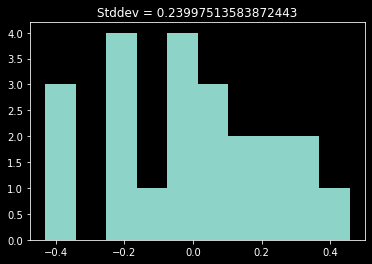

In [58]:
_=pl.hist(residuals_hgkrnemodel_nedata)
_=pl.title(f"Stddev = {residuals_hgkrnemodel_nedata.std()}")

This histogram is perhaps a little skewed.

There may be some curvature to this spectrum, but the evidence is not terribly compelling, particularly given the uncertain nature of the Neon line fits.

## What is our uncertainty?

To evaluate our uncertainty, let's first look at the uncertainty in the pixel value inferred from looking at a single line in the mercury spectrum.

Text(0.5, 0, 'Pixel Index Number')

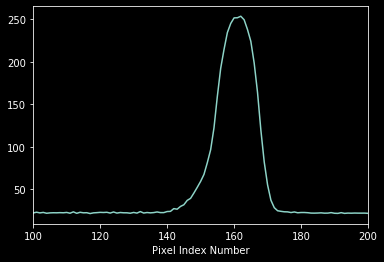

In [59]:
pl.plot(xaxis, hg_spectrum)
pl.xlim(100,200)
pl.xlabel("Pixel Index Number")

We can get a *coarse* empirical estimate of the per-pixel uncertainty by taking the standard deviation of a "blank" part of the spectrum:

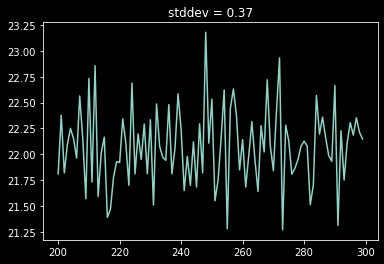

In [60]:
pl.plot(xaxis[200:300], hg_spectrum[200:300])
noise_estimate = hg_spectrum[200:300].std()
_=pl.title(f"stddev = {noise_estimate:0.2f}")

The moment-1 estimate of the peak location is, for a spectrum $f(x)$ and pixel location $x$ 
$$ m_1 = \frac{\Sigma x f(x)}{\Sigma f(x)} $$

which, through propagation of error, gives us variance of moment 1:

$$\sigma_{m_1}^2 =  \left(\frac{\Sigma \left[ (x-m_1)^2   \sigma_{f(x)}^2 \right]}{\left(\Sigma f(x)\right)^2}  +
   \frac{\sigma_{\Sigma f(x)}^2 \Sigma \left[ (x-m_1)^2 f(x)^2 \right]}{\left(\Sigma f(x)\right)^4} \right)$$
   
   where 
$   \sigma_{\Sigma f(x)}^2 = \Sigma \sigma_{f(x)}^2 = N \sigma_{f(x)}^2 $

In [61]:
cutout = hg_spectrum[100:200] - np.median(hg_spectrum)
xcutout = xaxis[100:200]
m1 = (xcutout * cutout).sum() / cutout.sum()
m1

160.1508577103591

In [62]:
# Uncertainty on moment 1
sigma_m1_left = ((xcutout-m1)**2 * noise_estimate**2).sum() / cutout.sum()**2
sigma_m1_right = (xcutout.size * noise_estimate**2) * ((xcutout-m1)**2*cutout**2).sum() / cutout.sum()**4
sigma_m1 = sigma_m1_left + sigma_m1_right
sigma_m1

0.0012382185077734265

In [63]:
print(f"Moment analysis yields m1 = {m1:0.3f} +/- {sigma_m1:0.3f})")

Moment analysis yields m1 = 160.151 +/- 0.001)


The uncertainty is about 1/1000th of a pixel for a bright line.  It may be somewhat larger for fainter lines, but it is still much smaller than our observed scatter. 

 We can prove that the uncertainty per line is negligible by looking at a faint neon line:

In [64]:
# cut out a line and compute its moment 1
cutoutne = ne_spectrum[640:660] - np.median(ne_spectrum)
xcutoutne = xaxis[640:660]
m1ne = (xcutoutne * cutoutne).sum() / cutoutne.sum()

In [65]:
# estimate the per-pixel error in the Neon spectrum
ne_noise_estimate = ne_spectrum[1400:1600].std()
ne_noise_estimate

1.0651670186867876

Text(0.5, 0, 'Pixel Coordinate')

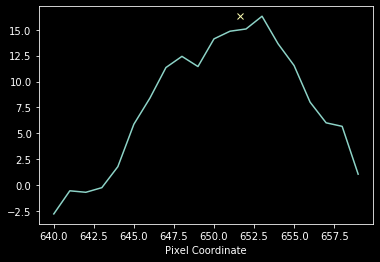

In [66]:
pl.plot(xcutoutne, cutoutne)
pl.plot(m1ne, cutoutne.max(), 'x')
pl.xlabel("Pixel Coordinate")

In [67]:
# calculate Neon line centroid uncertainty
sigma_m1_left = ((xcutoutne-m1ne)**2 * ne_noise_estimate**2).sum() / cutoutne.sum()**2
sigma_m1_right = (xcutoutne.size * ne_noise_estimate**2) * ((xcutoutne-m1ne)**2*cutoutne**2).sum() / cutoutne.sum()**4
sigma_m1_ne = sigma_m1_left + sigma_m1_right
sigma_m1_ne

0.0371083183741168

In [68]:
print(f"Moment analysis for the faint Neon line yields m1 = {m1ne:0.4f} +/- {sigma_m1_ne:0.4f}) pixels")

Moment analysis for the faint Neon line yields m1 = 651.6098 +/- 0.0371) pixels


This error is ~40 times larger, but still much less than a pixel's width.

Our best fit gives that each pixel is about 0.1 nm, so our uncertainty is 0.0001 nm - 0.004 nm.  The scatter in the residuals is 0.23 nm, so it is not explained by our formal fit's statistical uncertainty. 

In [69]:
print(f"Standard Deviation of the residuals = {residuals_hgkrnemodel_nedata.std()} nm, "
      f"Faint Line uncertainty = {sigma_m1_ne * linfit_wlmodel_hgkrne.slope} nm")

Standard Deviation of the residuals = 0.23997513583872443 nm, Faint Line uncertainty = -0.0037901110990412232 nm


## What does the residual represent?

The residual to our fit gives us a sense of the *systematic* uncertainty from a combination of line blending and imperfect fits.  We know, from the NIST line lists, that there are in some cases multiple lines that we could not easily distinguish in the spectrum: these add a small bias to our inferred pixel locations.

There may also be subtle effects from the spectrograph itself that cause small systematic variations in the wavelength solution.

## How could we do better?

We could attempt to *deblend* the individual spectral features by jointly fitting multiple-Gaussian models.

While this procedure is commonly used, it is fraught with error and extremely difficult to automate in general.

You're done!  Now apply this calibration to the data and start measuring things.

In [ ]:
# these lines downselect from the table to keep only those that have usable "Relative Intensity" measurements
# first, we get rid of those whose 'Rel.' column is masked out or is an asterisk
hg_keep = (~mercury_lines['Rel.'].mask) & (mercury_lines['Rel.'] != "*")
hg_wl_tbl = mercury_lines['Observed'][hg_keep]
# then, we collect the 'Rel.' values and convert them from strings to floats
hg_rel_tbl = np.array([float(x) for x in mercury_lines['Rel.'][hg_keep]])

In [70]:
mercury_lines

Observed,Ritz,Transition,Rel.,Aki,fik,Acc.,Ei Ek,Lower level,Upper level,Type,TP,Line
float64,float64,float64,str5,float64,float64,str2,str25,str34,str34,str2,str5,str8
402.709,402.715,24831.8,4,--,--,--,7.9260766 - 11.00479,5d10.6s.7s | 1S | 0,5d9.6s2.(2D<3/2>).6p | 2[1/2]* | 1,--,--,L7588c86
404.77081,404.77074,24705.339,12000,20700000.0,0.152,B,4.6673829 - 7.7304550,5d10.6s.6p | 3P* | 0,5d10.6s.7s | 3S | 1,--,T5292,L7247
407.89883,407.89883,24515.883,1000,4000000.0,0.0033,B,4.8864946 - 7.9260766,5d10.6s.6p | 3P* | 1,5d10.6s.7s | 1S | 0,--,T5292,L7247
410.9213,410.9214,24335.56,70,2200000.0,0.0019,D,6.7036623 - 9.720887,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 1S | 0,--,T3462,L3451
414.12,414.1226,24147.8,0,--,--,--,6.7036623 - 9.697563,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 3S | 1,--,--,L7587c86
431.526,431.5399,23173.8,1,--,--,--,6.7036623 - 9.576727,5d10.6s.6p | 1P* | 1,5d10.6s.5f | 1F* | 3,E2,--,L7589c86
434.04431,434.04428,23039.122,50,2900000.0,0.0136,C+,6.7036623 - 9.5601496,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 2,--,T5292,L3451
434.4855,434.4853,23015.73,1.3,--,--,--,6.7036623 - 9.5572499,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 1,--,--,L7593c86
434.87166,434.87172,22995.29,150,8400000.0,0.04,B,6.7036623 - 9.5547145,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 1D | 2,--,T5292,L3451


In [73]:
mercury_lines[~mercury_lines['Rel.'].mask]

Observed,Ritz,Transition,Rel.,Aki,fik,Acc.,Ei Ek,Lower level,Upper level,Type,TP,Line
float64,float64,float64,str5,float64,float64,str2,str25,str34,str34,str2,str5,str8
402.709,402.715,24831.8,4,--,--,--,7.9260766 - 11.00479,5d10.6s.7s | 1S | 0,5d9.6s2.(2D<3/2>).6p | 2[1/2]* | 1,--,--,L7588c86
404.77081,404.77074,24705.339,12000,20700000.0,0.152,B,4.6673829 - 7.7304550,5d10.6s.6p | 3P* | 0,5d10.6s.7s | 3S | 1,--,T5292,L7247
407.89883,407.89883,24515.883,1000,4000000.0,0.0033,B,4.8864946 - 7.9260766,5d10.6s.6p | 3P* | 1,5d10.6s.7s | 1S | 0,--,T5292,L7247
410.9213,410.9214,24335.56,70,2200000.0,0.0019,D,6.7036623 - 9.720887,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 1S | 0,--,T3462,L3451
414.12,414.1226,24147.8,0,--,--,--,6.7036623 - 9.697563,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 3S | 1,--,--,L7587c86
431.526,431.5399,23173.8,1,--,--,--,6.7036623 - 9.576727,5d10.6s.6p | 1P* | 1,5d10.6s.5f | 1F* | 3,E2,--,L7589c86
434.04431,434.04428,23039.122,50,2900000.0,0.0136,C+,6.7036623 - 9.5601496,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 2,--,T5292,L3451
434.4855,434.4853,23015.73,1.3,--,--,--,6.7036623 - 9.5572499,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 1,--,--,L7593c86
434.87166,434.87172,22995.29,150,8400000.0,0.04,B,6.7036623 - 9.5547145,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 1D | 2,--,T5292,L3451


In [75]:
mercury_lines[(mercury_lines['Rel.'] == "*")]

Observed,Ritz,Transition,Rel.,Aki,fik,Acc.,Ei Ek,Lower level,Upper level,Type,TP,Line
float64,float64,float64,str5,float64,float64,str2,str25,str34,str34,str2,str5,str8
467.4226,467.4228,21393.92,*,--,--,--,7.7304550 - 10.382961,5d10.6s.7s | 3S | 1,5d10.6s.20p | 3P* | 1,--,--,L11984
467.4226,467.4228,21393.92,*,--,--,--,7.7304550 - 10.382961,5d10.6s.7s | 3S | 1,5d10.6s.20p | 3P* | 0,--,--,L11984
468.7698,468.7697,21332.43,*,--,--,--,7.7304550 - 10.375340,5d10.6s.7s | 3S | 1,5d10.6s.19p | 3P* | 1,--,--,L11984
468.7698,468.7697,21332.43,*,--,--,--,7.7304550 - 10.375340,5d10.6s.7s | 3S | 1,5d10.6s.19p | 3P* | 0,--,--,L11984


In [76]:
hg_keep = (~mercury_lines['Rel.'].mask) & (mercury_lines['Rel.'] != "*")
hg_keep

masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, --, --, False, False, --, --, False, False, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, True, --, --, --, True, True, True,
                   True, --, --, True, True, True, True, True, --, True,
                   True, True, True, True, True, --, --, True, True, True],
             mask=[False, False, False, False, False, False, False, False,
                   False, False,  True,  True, False, False,  True,  True,
                   False, False,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True, False,  True,
                    True,  True, False, False, False, False,  True,  True,
                   False, False, False, False, False,  True, False, False,
                   False, Fals

In [77]:
mercury_lines[hg_keep]

Observed,Ritz,Transition,Rel.,Aki,fik,Acc.,Ei Ek,Lower level,Upper level,Type,TP,Line
float64,float64,float64,str5,float64,float64,str2,str25,str34,str34,str2,str5,str8
402.709,402.715,24831.8,4,--,--,--,7.9260766 - 11.00479,5d10.6s.7s | 1S | 0,5d9.6s2.(2D<3/2>).6p | 2[1/2]* | 1,--,--,L7588c86
404.77081,404.77074,24705.339,12000,20700000.0,0.152,B,4.6673829 - 7.7304550,5d10.6s.6p | 3P* | 0,5d10.6s.7s | 3S | 1,--,T5292,L7247
407.89883,407.89883,24515.883,1000,4000000.0,0.0033,B,4.8864946 - 7.9260766,5d10.6s.6p | 3P* | 1,5d10.6s.7s | 1S | 0,--,T5292,L7247
410.9213,410.9214,24335.56,70,2200000.0,0.0019,D,6.7036623 - 9.720887,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 1S | 0,--,T3462,L3451
414.12,414.1226,24147.8,0,--,--,--,6.7036623 - 9.697563,5d10.6s.6p | 1P* | 1,5d10.6s.9s | 3S | 1,--,--,L7587c86
431.526,431.5399,23173.8,1,--,--,--,6.7036623 - 9.576727,5d10.6s.6p | 1P* | 1,5d10.6s.5f | 1F* | 3,E2,--,L7589c86
434.04431,434.04428,23039.122,50,2900000.0,0.0136,C+,6.7036623 - 9.5601496,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 2,--,T5292,L3451
434.4855,434.4853,23015.73,1.3,--,--,--,6.7036623 - 9.5572499,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 3D | 1,--,--,L7593c86
434.87166,434.87172,22995.29,150,8400000.0,0.04,B,6.7036623 - 9.5547145,5d10.6s.6p | 1P* | 1,5d10.6s.7d | 1D | 2,--,T5292,L3451


In [78]:
ls

 README.txt
'Spectroscopic Trace Tutorial.ipynb'
'Spectroscopy Lab.ipynb'
'Trace, Extract, Wavelength-Calibrate a spectrum, then measure line properties.ipynb'
'Wavelength Calibration.ipynb'
 aldebaran_3s_1.bmp*
 aldebaran_3s_2.bmp*
 aldebaran_3s_3.bmp*
 aldebaran_3s_4.bmp*
 aldebaran_3s_5.bmp*
 dark_1d16s_1.bmp*
 dark_1d16s_2.bmp*
 dark_1d16s_3.bmp*
 dark_1d94s_1.bmp*
 dark_1d94s_2.bmp*
 dark_1d94s_3.bmp*
 dark_1s_1.bmp*
 dark_1s_2.bmp*
 dark_1s_3.bmp*
 dark_20p5s_1.bmp*
 dark_20p5s_2.bmp*
 dark_20p5s_3.bmp*
 dark_30s_1.bmp*
 dark_30s_2.bmp*
 dark_30s_3.bmp*
 dark_3s_1.bmp*
 dark_3s_2.bmp*
 dark_3s_3.bmp*
 dark_3s_4.bmp*
 dark_3s_5.bmp*
 dark_8s_1.bmp*
 dark_8s_2.bmp*
 dark_8s_3.bmp*
 dark_8s_4.bmp*
 dark_8s_5.bmp*
 dark_9s_1.bmp*
 dark_9s_2.bmp*
 dark_9s_3.bmp*
 dark_9s_4.bmp*
 dark_9s_5.bmp*
 dark_p6s_1.bmp*
 dark_p6s_2.bmp*
 dark_p6s_3.bmp*
 deneb_3s_13.63g_1.bmp*
 deneb_3s_13.63g_2.bmp*
 deneb_3s_13.63g_3.bmp*
 flat_20p5s.bmp*
 flat_20p5s_2.bmp*
 flat_20p5s_3.bmp*
 hg_lamp_1-sixte